In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [153]:
df = pd.read_csv('GOOG.csv', date_parser=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,312.304413,313.579620,310.954468,312.204773,312.204773,3927000
1,2010-01-05,312.418976,312.747742,309.609497,310.829926,310.829926,6031900
2,2010-01-06,311.761444,311.761444,302.047852,302.994293,302.994293,7987100
3,2010-01-07,303.562164,303.861053,295.218445,295.940735,295.940735,12876600
4,2010-01-08,294.894653,300.498657,293.455048,299.885956,299.885956,9483900


In [154]:
from collections import deque
import random

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.01
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.compat.v1.reset_default_graph()
        self.X = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.compat.v1.placeholder(tf.float32, (None))
        self.REWARD = tf.compat.v1.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.compat.v1.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.compat.v1.layers.dense(state_action, 32, activation='relu')
            self.curiosity_logits = tf.compat.v1.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.compat.v1.train.AdamOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.compat.v1.variable_scope("q_model"):
            with tf.compat.v1.variable_scope("eval_net"):
                x_action = tf.compat.v1.layers.dense(self.X, 128, 'relu')
                tensor_action, tensor_validation = tf.split(x_action,2,1)
                feed_action = tf.compat.v1.layers.dense(tensor_action, self.OUTPUT_SIZE)
                feed_validation = tf.compat.v1.layers.dense(tensor_validation, 1)
                self.logits = feed_validation + \
                tf.subtract(feed_action,tf.math.reduce_mean(feed_action,axis=1,keepdims=True))
            
            with tf.compat.v1.variable_scope("target_net"):
                y_action = tf.compat.v1.layers.dense(self.Y, 128, 'relu')
                tensor_action, tensor_validation = tf.split(y_action,2,1)
                feed_action = tf.compat.v1.layers.dense(tensor_action, self.OUTPUT_SIZE)
                feed_validation = tf.compat.v1.layers.dense(tensor_validation, 1)
                y_q = feed_validation + \
                tf.subtract(feed_action,tf.math.reduce_mean(feed_action,axis=1,keepdims=True))
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.keras.losses.MSE(q_target, q)
            self.optimizer = tf.compat.v1.train.AdamOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.compat.v1.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [155]:
tf.compat.v1.disable_eager_execution()
close = df.Close.values.tolist()
initial_money = 500
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 300, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 717.982024.3, cost: 26557294.000000, total money: 1217.982024
epoch: 20, total rewards: 28.470788.3, cost: 11679592.000000, total money: 528.470788
epoch: 30, total rewards: 15.518838.3, cost: 430486.468750, total money: 515.518838
epoch: 40, total rewards: 786.218578.3, cost: 870473.500000, total money: 1286.218578
epoch: 50, total rewards: 56.364195.3, cost: 222550.218750, total money: 556.364195
epoch: 60, total rewards: 292.820383.3, cost: 97113.687500, total money: 792.820383
epoch: 70, total rewards: -2.043224.3, cost: 245070.406250, total money: 497.956776
epoch: 80, total rewards: 232.950453.3, cost: 662296.500000, total money: 732.950453
epoch: 90, total rewards: 342.910967.3, cost: 2093506.500000, total money: 842.910967
epoch: 100, total rewards: -4.468397.3, cost: 872415.937500, total money: 495.531603
epoch: 110, total rewards: 672.360598.3, cost: 222629.765625, total money: 1172.360598
epoch: 120, total rewards: 56.856487.3, cost: 135881.687500, 

In [156]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 312.204773, total balance 187.795227
day 6, sell 1 unit at price 294.137512, investment -5.786991 %, total balance 481.932739,
day 10: buy 1 unit at price 292.712830, total balance 189.219909
day 12, sell 1 unit at price 290.401489, investment -0.789627 %, total balance 479.621398,
day 16: buy 1 unit at price 270.037842, total balance 209.583556
day 19, sell 1 unit at price 265.514771, investment -1.674977 %, total balance 475.098327,
day 20: buy 1 unit at price 264.568329, total balance 210.529998
day 23, sell 1 unit at price 264.653015, investment 0.032009 %, total balance 475.183013,
day 24: buy 1 unit at price 265.738953, total balance 209.444060
day 27, sell 1 unit at price 267.198486, investment 0.549236 %, total balance 476.642546,
day 30: buy 1 unit at price 268.100098, total balance 208.542448
day 31, sell 1 unit at price 270.595734, investment 0.930860 %, total balance 479.138182,
day 51: buy 1 unit at price 282.142456, total balance 196.995726
day 

day 637: buy 1 unit at price 287.183563, total balance 129.673018
day 647, sell 1 unit at price 316.294464, investment 10.136688 %, total balance 445.967482,
day 654: buy 1 unit at price 319.074036, total balance 126.893446
day 662, sell 1 unit at price 337.305695, investment 5.713927 %, total balance 464.199141,
day 665: buy 1 unit at price 337.325623, total balance 126.873518
day 666, sell 1 unit at price 337.136322, investment -0.056118 %, total balance 464.009840,
day 683: buy 1 unit at price 357.798889, total balance 106.210951
day 691, sell 1 unit at price 375.841248, investment 5.042598 %, total balance 482.052199,
day 695: buy 1 unit at price 382.590942, total balance 99.461257
day 697, sell 1 unit at price 377.505005, investment -1.329341 %, total balance 476.966262,
day 707: buy 1 unit at price 338.067841, total balance 138.898421
day 712, sell 1 unit at price 338.879791, investment 0.240174 %, total balance 477.778212,
day 719: buy 1 unit at price 330.277039, total balance 1

day 1418: buy 1 unit at price 612.479980, total balance 8.145030
day 1426, sell 1 unit at price 614.340027, investment 0.303691 %, total balance 622.485057,
day 1428: buy 1 unit at price 600.700012, total balance 21.785045
day 1429, sell 1 unit at price 614.659973, investment 2.323949 %, total balance 636.445018,
day 1434: buy 1 unit at price 635.140015, total balance 1.305003
day 1436, sell 1 unit at price 642.900024, investment 1.221779 %, total balance 644.205027,
day 1439: buy 1 unit at price 622.690002, total balance 21.515025
day 1441, sell 1 unit at price 625.799988, investment 0.499444 %, total balance 647.315013,
day 1442: buy 1 unit at price 611.969971, total balance 35.345042
day 1447, sell 1 unit at price 626.909973, investment 2.441297 %, total balance 662.255015,
day 1452: buy 1 unit at price 643.609985, total balance 18.645030
day 1456, sell 1 unit at price 661.739990, investment 2.816924 %, total balance 680.385020,
day 1535: buy 1 unit at price 678.109985, total balanc

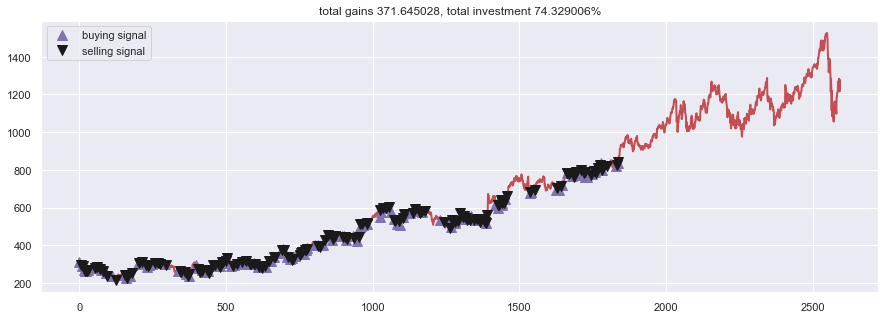

In [157]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()